In [17]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [18]:
# 2. LOAD DATA
path = "https://gitlab.crio.do/me_notebook/me_jupyter_uberanalysis/-/raw/master/Uber_ride_analysis_dataset.csv"
df = pd.read_csv(path)

df.head()

,Request id,Pickup point,Drop point,Request timestamp,Start timestamp,Drop timestamp,Trip Cost,Extra Tip,Driver id,Trip Status,Ride Type,Payment Method,Weather
0,4386.0,Majestic Bus Station,Bangalore Palace,2021-07-13 0:00:24,NaN,NaN,0.00,0.0,61.0,Trip Cancelled,UberXL,NaN,Clear
1,4387.0,Lalbagh Botanical Garden,Indiranagar,2021-07-13 0:02:14,2021-07-13 0:16:00,2021-07-13 0:26:14,111.38,0.0,17.0,Trip Completed,UberGo,Cash,Cloudy
2,4388.0,Lalbagh Botanical Garden,Kormangala Police Station,2021-07-13 0:06:34,2021-07-13 0:14:01,2021-07-13 2:01:34,89.00,25.0,21.0,Trip Completed,UberXL,Card,Clear
3,4389.0,Majestic Bus Station,ISKCON Temple,2021-07-13 0:07:31,NaN,NaN,0.00,0.0,NaN,No Cars Available,UberXL,NaN,Rainy
4,4390.0,Bangalore City Railway Station,Lalbagh Botanical Garden,2021-07-13 0:07:58,2021-07-13 0:20:21,2021-07-13 0:40:58,307.40,25.0,35.0,Trip Completed,UberGo,Cash,Rainy


In [20]:
# 3. DATA CLEANING & PREPROCESSING

df.columns = (
    df.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

df.columns

# Convert timestamps to datetime
timestamp_cols = [
    'request_timestamp',
    'start_timestamp',
    'drop_timestamp'
]

for col in timestamp_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Standardize text columns
text_cols = ['pickup_point', 'drop_point', 'ride_type', 'payment_method', 'trip_status', 'weather']
for col in text_cols:
    df[col] = df[col].str.strip().str.title()

# Check missing values
df.isnull().sum()


,0
request_id,200
pickup_point,200
drop_point,200
request_timestamp,200
start_timestamp,1850
drop_timestamp,1850
trip_cost,200
extra_tip,200
driver_id,975
trip_status,200


In [21]:
# 4. FEATURE ENGINEERING

# Temporal features
df['request_hour'] = df['request_timestamp'].dt.hour
df['request_day'] = df['request_timestamp'].dt.day_name()

# Wait time (minutes)
df['wait_time'] = (
    df['start_timestamp'] - df['request_timestamp']
).dt.total_seconds() / 60

# Trip duration (minutes)
df['trip_duration'] = (
    df['drop_timestamp'] - df['start_timestamp']
).dt.total_seconds() / 60

# Peak vs Off-Peak
df['time_category'] = np.where(
    df['request_hour'].between(8, 10) | df['request_hour'].between(18, 20),
    'Peak',
    'Off-Peak'
)

df.head()


,request_id,pickup_point,drop_point,request_timestamp,start_timestamp,drop_timestamp,trip_cost,extra_tip,driver_id,trip_status,ride_type,payment_method,weather,request_hour,request_day,wait_time,trip_duration,time_category
0,4386.0,Majestic Bus Station,Bangalore Palace,2021-07-13 00:00:24,NaT,NaT,0.00,0.0,61.0,Trip Cancelled,Uberxl,NaN,Clear,0.0,Tuesday,NaN,NaN,Off-Peak
1,4387.0,Lalbagh Botanical Garden,Indiranagar,2021-07-13 00:02:14,2021-07-13 00:16:00,2021-07-13 00:26:14,111.38,0.0,17.0,Trip Completed,Ubergo,Cash,Cloudy,0.0,Tuesday,13.766667,10.233333,Off-Peak
2,4388.0,Lalbagh Botanical Garden,Kormangala Police Station,2021-07-13 00:06:34,2021-07-13 00:14:01,2021-07-13 02:01:34,89.00,25.0,21.0,Trip Completed,Uberxl,Card,Clear,0.0,Tuesday,7.450000,107.550000,Off-Peak
3,4389.0,Majestic Bus Station,Iskcon Temple,2021-07-13 00:07:31,NaT,NaT,0.00,0.0,NaN,No Cars Available,Uberxl,NaN,Rainy,0.0,Tuesday,NaN,NaN,Off-Peak
4,4390.0,Bangalore City Railway Station,Lalbagh Botanical Garden,2021-07-13 00:07:58,2021-07-13 00:20:21,2021-07-13 00:40:58,307.40,25.0,35.0,Trip Completed,Ubergo,Cash,Rainy,0.0,Tuesday,12.383333,20.616667,Off-Peak


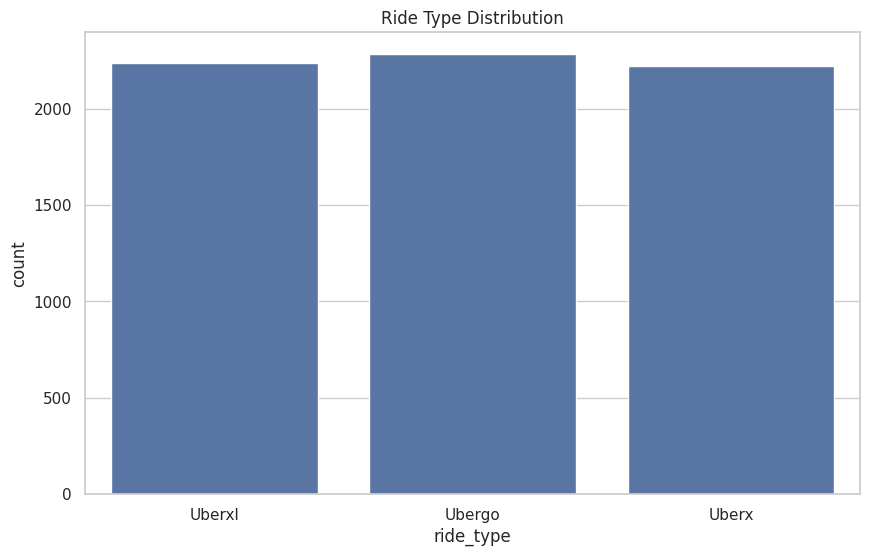

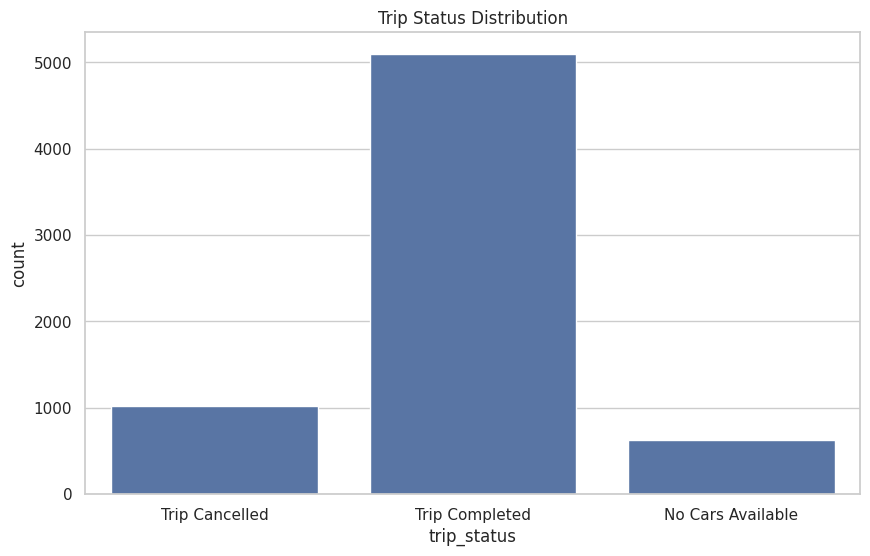

In [22]:
# 5. UNIVARIATE ANALYSIS

# Ride type distribution
sns.countplot(data=df, x='ride_type')
plt.title("Ride Type Distribution")
plt.show()

# Trip status distribution
sns.countplot(data=df, x='trip_status')
plt.title("Trip Status Distribution")
plt.show()


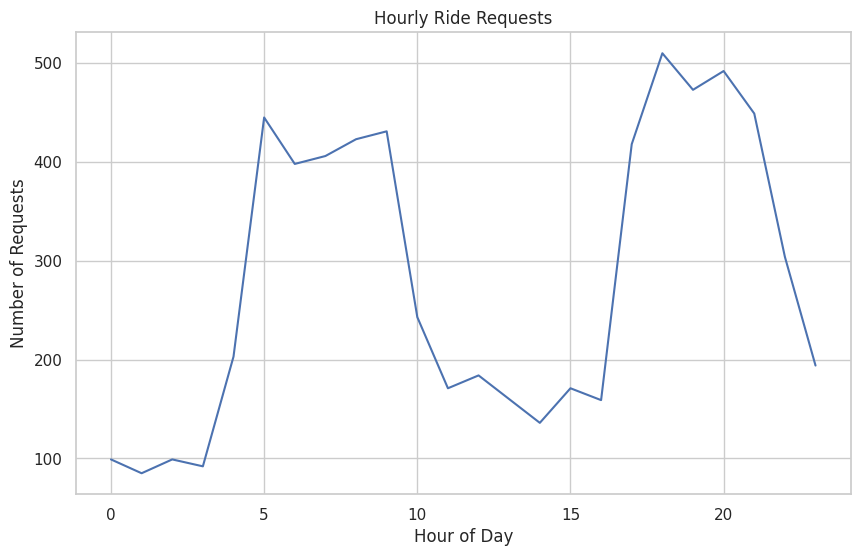

In [23]:
# 6. TEMPORAL DEMAND ANALYSIS

hourly_requests = df.groupby('request_hour')['request_id'].count()

sns.lineplot(x=hourly_requests.index, y=hourly_requests.values)
plt.title("Hourly Ride Requests")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.show()


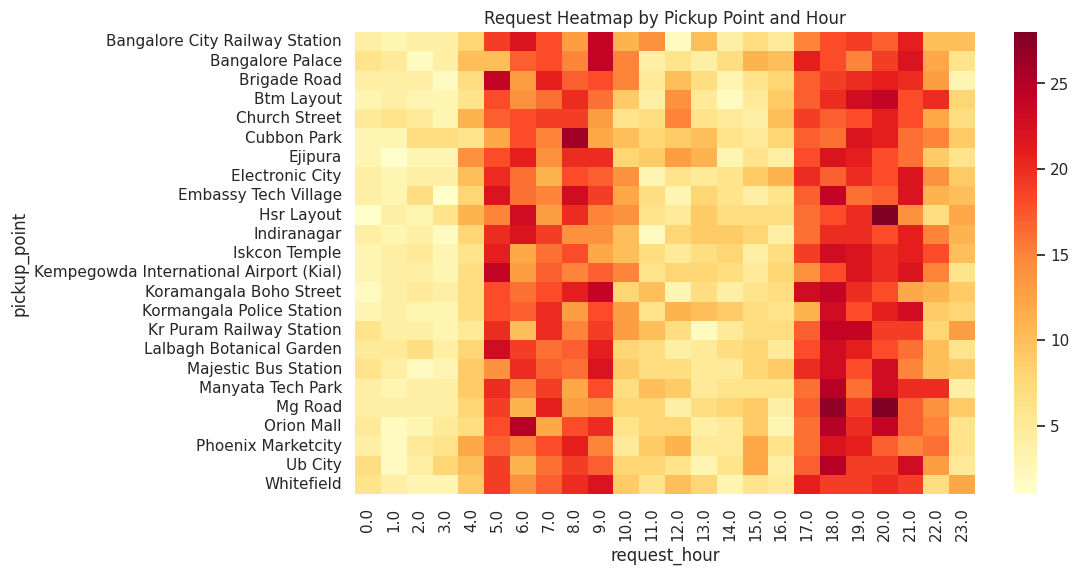

In [24]:
# 7. HEATMAP: REQUESTS BY HOUR & PICKUP POINT

heatmap_data = df.pivot_table(
    index='pickup_point',
    columns='request_hour',
    values='request_id',
    aggfunc='count'
)

sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title("Request Heatmap by Pickup Point and Hour")
plt.show()


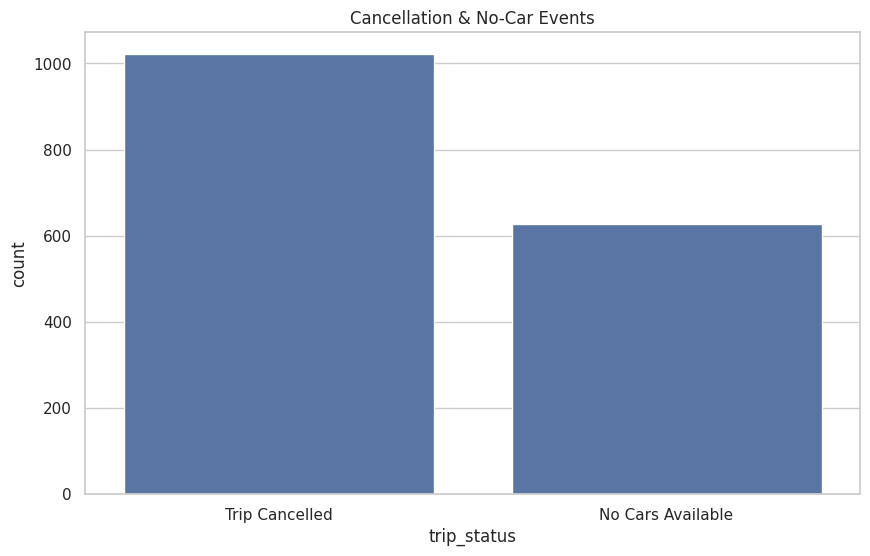

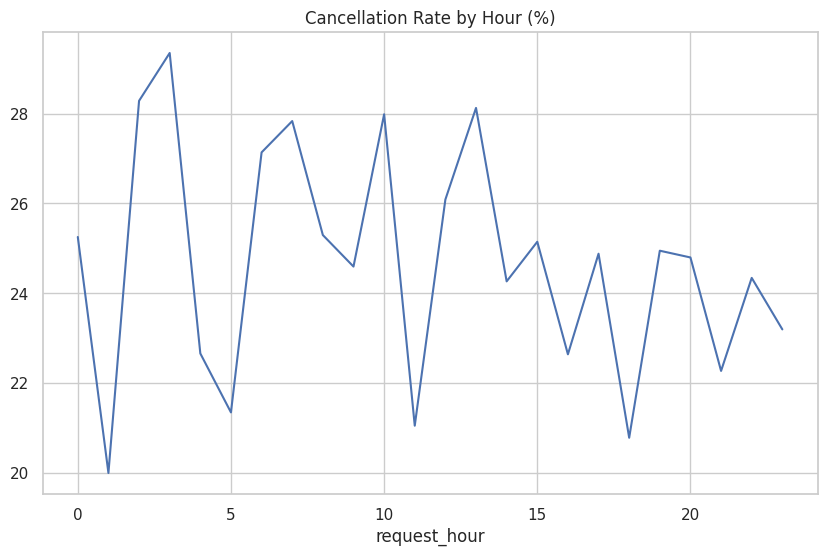

In [25]:
# 8. CANCELLATION & NO-CAR ANALYSIS

cancel_df = df[df['trip_status'] != 'Trip Completed']

sns.countplot(data=cancel_df, x='trip_status')
plt.title("Cancellation & No-Car Events")
plt.show()

# Cancellation rate by hour
cancel_rate = (
    cancel_df.groupby('request_hour')['request_id'].count()
    / df.groupby('request_hour')['request_id'].count()
) * 100

sns.lineplot(x=cancel_rate.index, y=cancel_rate.values)
plt.title("Cancellation Rate by Hour (%)")
plt.show()


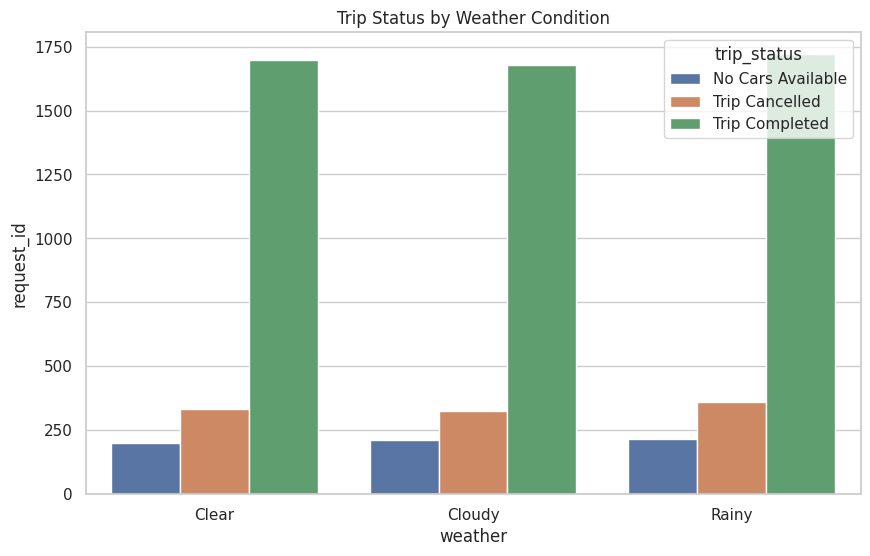

In [26]:
# 9. WEATHER IMPACT ANALYSIS

weather_cancel = df.groupby(['weather', 'trip_status'])['request_id'].count().reset_index()

sns.barplot(
    data=weather_cancel,
    x='weather',
    y='request_id',
    hue='trip_status'
)
plt.title("Trip Status by Weather Condition")
plt.show()


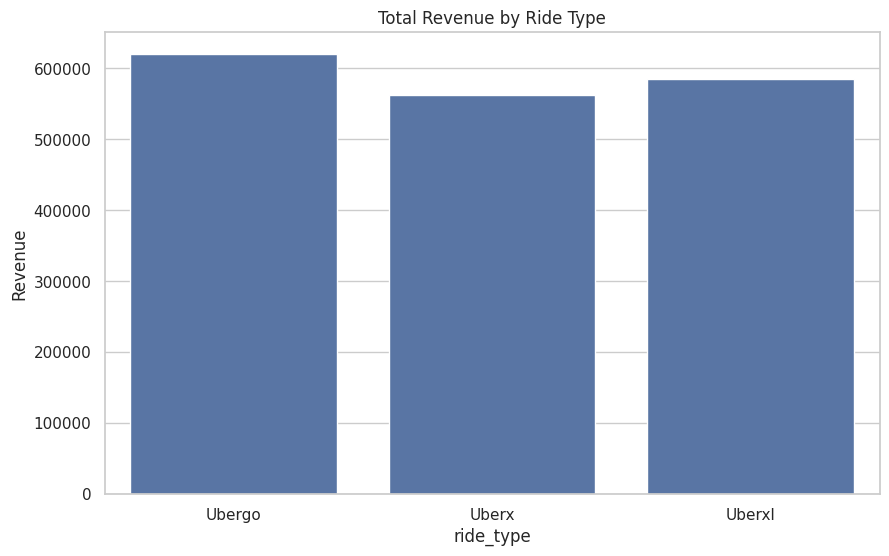

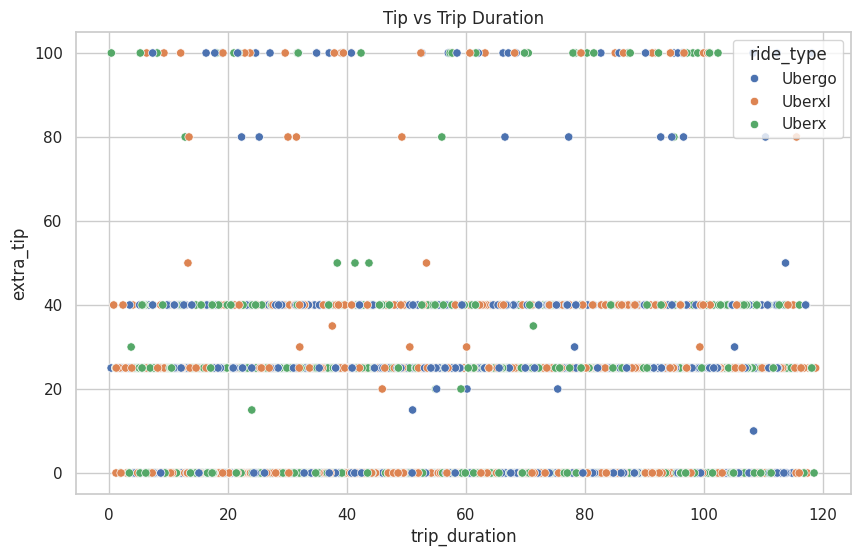

In [27]:
# 10. REVENUE ANALYSIS

# Use only completed trips
completed_df = df[df['trip_status'] == 'Trip Completed']

# Revenue by ride type
revenue_by_type = completed_df.groupby('ride_type')['trip_cost'].sum()

sns.barplot(x=revenue_by_type.index, y=revenue_by_type.values)
plt.title("Total Revenue by Ride Type")
plt.ylabel("Revenue")
plt.show()

# Tip vs Duration
sns.scatterplot(
    data=completed_df,
    x='trip_duration',
    y='extra_tip',
    hue='ride_type'
)
plt.title("Tip vs Trip Duration")
plt.show()


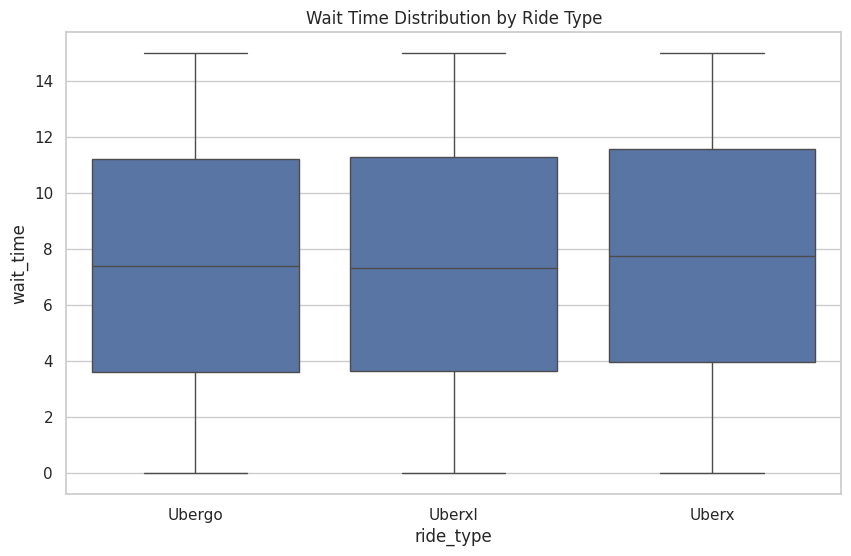

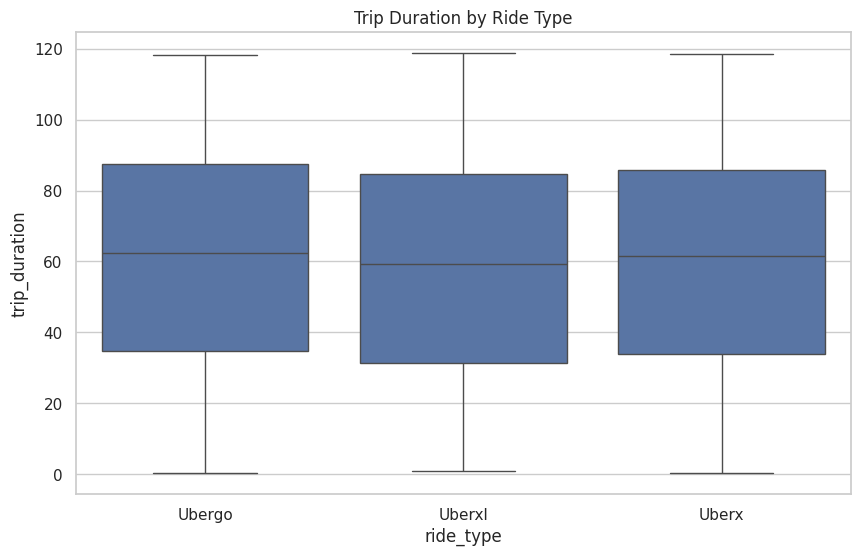

In [28]:
# 11. BOXPLOTS: WAIT TIME & DURATION

sns.boxplot(data=completed_df, x='ride_type', y='wait_time')
plt.title("Wait Time Distribution by Ride Type")
plt.show()

sns.boxplot(data=completed_df, x='ride_type', y='trip_duration')
plt.title("Trip Duration by Ride Type")
plt.show()
